# Task E - This relation is a mess!, The “triangle” problem

In [1]:
import numpy as np
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized , acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
from numpy.random import random, seed
from fireworks.particles import Particles
from fireworks.nbodylib.timesteps import adaptive_timestep_simple, adaptive_timestep_r

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

Let's put in the particles (rebember that the units are Nbody units).

In [2]:
tevolve    = 65
position = np.array([[1., 3.,0.], [-2., -1., 0.], [1., -1., 0]])
#position   = np.array([[0.,0.,0.],[0.5, 0.866,0],[1,0,0]])
velocity   = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
mass       = np.array([3.,4.,5.])
P          = Particles(position,velocity,mass)
print(P.pos )                                                                  # particles'positions
print(P.vel )                                                                  # particles'velocities
print(P.mass)                                                                  # particles'masses
print(P.ID  )                                                                  # particles'unique IDs

part_init = P.copy()
pos_init_1 = part_init.pos[0]
pos_init_2 = part_init.pos[1]
pos_init_3 = part_init.pos[2]

[[ 1.  3.  0.]
 [-2. -1.  0.]
 [ 1. -1.  0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[3. 4. 5.]
[0 1 2]


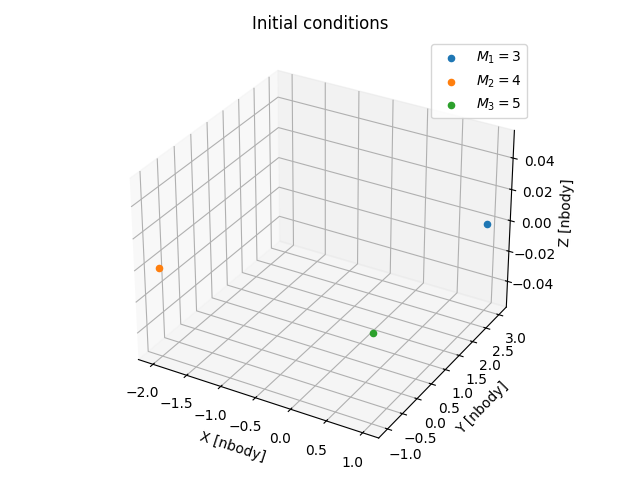

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pos_init_1[0], pos_init_1[1], pos_init_1[2], label=f'$M_1 = 3$', color='C0')
ax.scatter(pos_init_2[0], pos_init_2[1], pos_init_2[2], label=f'$M_2 = 4$', color='C1')
ax.scatter(pos_init_3[0], pos_init_3[1], pos_init_3[2], label=f'$M_3 = 5$', color='C2')
ax.set_xlabel('X [nbody]')
ax.set_ylabel('Y [nbody]')
ax.set_zlabel('Z [nbody]')

plt.title('Initial conditions')

plt.legend()
plt.tight_layout()
plt.show()

### TSUNAM EVOLUTION

Now we can evolve the system using the TSUNAMI integrator. 

As initial condition we put $t_{start} = 0$ and $t_{simulation} = t_{evolve} = 65$ defined previously. To perform the integration we use a timestep of $h=0.001$.

In [4]:
def integration_with_tsunami_3body(part, tsimulation):
    tstart=0
    tintermediate = np.arange(tstart, tsimulation, 0.001) 
    tcurrent=0
    pos1_tsu = []
    pos2_tsu = []
    pos3_tsu = []
    #Epot_tsu = []
    #Ekin_tsu = []
    #Etot_tsu = []
    t_tsunami = []

    for t in tintermediate:
        tstep=t-tcurrent
        if tstep <=0: continue 
        part_tsunami, efftime,_,_,_=integrator_tsunami(part, tstep)

        # append the positions
        pos1_tsu.append(part_tsunami.pos[0].copy())
        pos2_tsu.append(part_tsunami.pos[1].copy())
        pos3_tsu.append(part_tsunami.pos[2].copy())

        # append the energies
        #Etot_n, Ekin_n, Epot_n =  part_tsunami.Etot()
        #Etot_tsu.append(Etot_n)
        #Ekin_tsu.append(Ekin_n)
        #Epot_tsu.append(Epot_n)

        # append the times
        t_tsunami.append(tcurrent)

        tcurrent=tcurrent+efftime

    # transform everything in numpy arrays
    pos1_tsu    = np.array(pos1_tsu)
    pos2_tsu    = np.array(pos2_tsu)
    pos3_tsu    = np.array(pos3_tsu)
    #Epot_tsu    = np.array(Epot_tsu)
    #Ekin_tsu    = np.array(Ekin_tsu)
    #Etot_tsu    = np.array(Etot_tsu)
    t_tsunami   = np.array(t_tsunami)


    return pos1_tsu, pos2_tsu, pos3_tsu, t_tsunami #, Epot_tsu, Ekin_tsu, Etot_tsu

In [5]:
P_tsu = P.copy()

In [6]:
pos1_tsu, pos2_tsu, pos3_tsu, t_tsu = integration_with_tsunami_3body(P_tsu, tevolve)

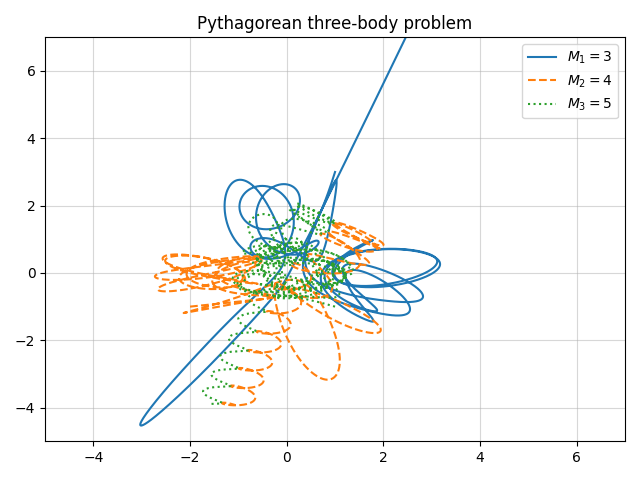

In [7]:
plt.figure()
plt.plot(pos1_tsu[:,0], pos1_tsu[:,1], label=f'$M_1 = 3$')
plt.plot(pos2_tsu[:,0], pos2_tsu[:,1], label=f'$M_2 = 4$', linestyle='dashed' ) 
plt.plot(pos3_tsu[:,0], pos3_tsu[:,1], label=f'$M_3 = 5$', linestyle='dotted' )
plt.ylim(-5,7)
plt.xlim(-5,7)
plt.legend()
plt.grid(True, alpha=0.5)
plt.title('Pythagorean three-body problem')
plt.tight_layout()

plt.savefig('./images/threebody_tsunami.png')

### OTHER INTEGRATORS

Let's begin with the `euler_integrator` and let's use the `acceleration_pyfalcon`. These are the fastest among the other analogous competitors.

In [8]:
def integration_euler_adaptive(part, h, tsimulation, t, N, softening):
    path_1 = []
    path_2 = []
    path_3 = []
    time   = []
    time2  = []
    Etot_euler = []
    Ekin_euler = []
    Epot_euler = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_euler(part, h, acceleration_pyfalcon, softening)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            path_3.append(updated_part.pos[2])

            '''
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_euler.append(Etot_n)
            Ekin_euler.append(Ekin_n)
            Epot_euler.append(Epot_n)
            '''
        
        ts_1, _, _ = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    path_3 = np.array(path_3)
    time   = np.array(time)
    time2  = np.array(time2)
    #Etot_euler = np.array(Etot_euler)
    #Ekin_euler = np.array(Ekin_euler)
    #Etot_euler = np.array(Epot_euler)

    return path_1, path_2, path_3



In [9]:
P_euler = P.copy()
print(P_euler.pos)
print(P_euler.vel)
print(P_euler.mass)

h = 0.1
N = 3
t = 0
softening = 0.78 # provare con softening diversi per avere un risultato simile a tsunami

[[ 1.  3.  0.]
 [-2. -1.  0.]
 [ 1. -1.  0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[3. 4. 5.]


In [10]:
path_1_euler, path_2_euler, path_3_euler = integration_euler_adaptive(P_euler, h, tevolve, t, N, softening)

KeyboardInterrupt: 

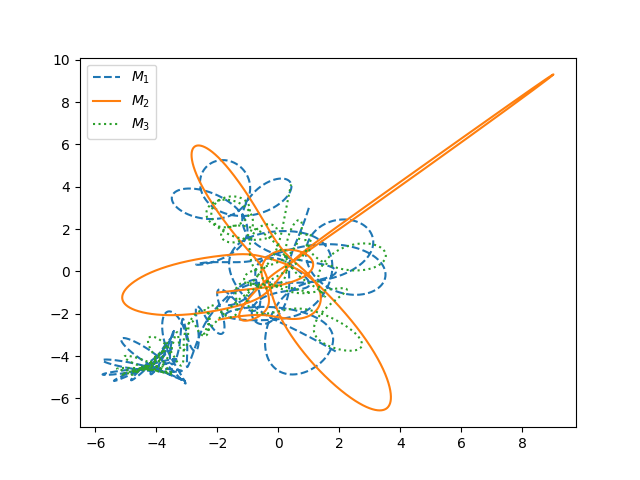

In [ ]:
plt.figure()
plt.plot(path_1_euler[:,0]  , path_1_euler[:,1], label=f'$M_1$', linestyle='dashed' ) # , pos1_tsu[:,2])
plt.plot(path_2_euler[:,0]  , path_2_euler[:,1], label=f'$M_2$') # , pos2_tsu[:,2])
plt.plot(path_3_euler[:,0]  , path_3_euler[:,1], label=f'$M_3$', linestyle='dotted' ) # , pos3_tsu[:,2])
plt.legend()

#plt.savefig('./images/threebody_euler.png')

## Animation

In [ ]:
import matplotlib.animation as anim

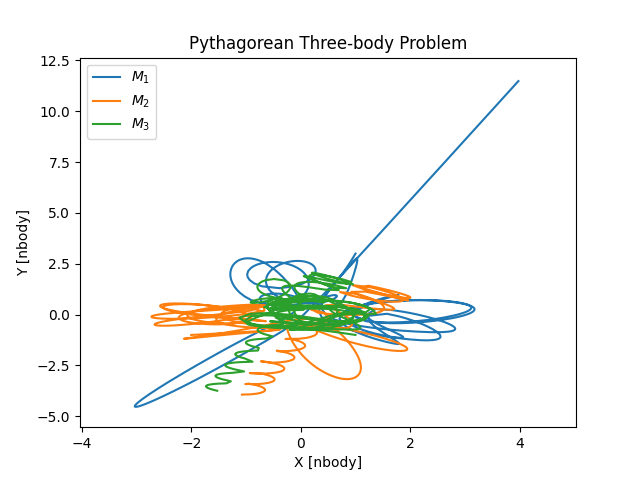

In [ ]:
'''
path_length = len(pos1_tsu)
subsample = 70

#time = time_euler_2[::subsample]

x1 = pos1_tsu[::subsample, 0]
y1 = pos1_tsu[::subsample, 1]
x2 = pos2_tsu[::subsample, 0]
y2 = pos2_tsu[::subsample, 1]
x3 = pos3_tsu[::subsample, 0]
y3 = pos3_tsu[::subsample, 1]

fig, ax = plt.subplots()


traj_1, = ax.plot([], [], label=f'$M_1$', color = 'C0')  
traj_2, = ax.plot([], [], label=f'$M_2$', color = 'C1')
traj_3, = ax.plot([], [], label=f'$M_3$', color = 'C2')
#time_template = 'time = %.1f [nbody]'
#time_text = ax.text(310, -40, '') #, transform=ax.transAxes)

ax.set_xlim(min(min(x1),min(x2),min(x3))-1, max(max(x1),max(x2),max(x3))+1)
ax.set_ylim(min(min(y1),min(y2),min(y3))-1, max(max(y1),max(y2),max(y3))+1)


def animate(i):
    traj_1.set_data(x1[:i], y1[:i])  # Update the data for trajectory 1
    traj_2.set_data(x2[:i], y2[:i])  # Update the data for trajectory 2
    traj_3.set_data(x3[:i], y3[:i])  # Update the data for trajectory 2
    #time_text.set_text(time_template % (time[i-1]))

    return traj_1, traj_2, traj_3

frames = int(np.ceil(path_length / subsample))
animation = anim.FuncAnimation(fig, animate, frames=frames, blit=True)

plt.title('Pythagorean Three-body Problem')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()  
animation.save('three_body.gif', writer = 'pillow', fps = 60)
'''